<a href="https://colab.research.google.com/github/adrianrivas/machinelearning/blob/main/clasificacion_binaria_banking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Contexto**

El siguiente es un problema de clasificación, cuyo objetivo es predecir si un cliente de un banco tomará o no un CDT (déposito a término) ofrecido en una campaña de telemarketing. Lo anterior, con el proposito de enfocar recursos valiosos, como lo son el tiempo y dinero, en verdaderos clientes potenciales.

El dataset contiene en 49732 registros y 17 columnas:

Datos del cliente:
1. age: edad
2. job: tipo de trabajo ("admin.","unknown","unemployed","management","housemaid","entrepreneur","student", "blue-collar","self-employed","retired","technician","services")
3. marital : estado civil ("married","divorced","single")
4. education: nivel de educación (categorical: "unknown","secondary","primary","tertiary")
5. default: Tiene deudas (créditos) con el banco? (binary: "yes","no")
6. balance: balance de cuenta anual promedio, en euros (numeric)
7. housing: crédito de vivienda (binary: "yes","no")
8. loan: créditos personales (binary: "yes","no")


Datos del último contacto en campaña de telemarketing:
9. contact: tipo de contacto (categorical: "unknown","telephone","cellular")
10. day: último día del mes contactado (numeric)
11. month: último mes de contacto (categorical: "jan", "feb", "mar", …, "nov", "dec")
12. duration: duración del último contacto en segundos (numeric)


Otros atributos:
13. campaign: número de veces que se ha contactado al cliente durante la campaña (numeric, includes last contact)
14. pdays: número de días que han pasado desde la última vez que se contacto al cliente (numeric, -1 significa que no se ha contactado previamente)
15. previous: número de veces que se ha contactado al cliente en campañas previas (numeric)
16. poutcome: resultado de la última campaña (categorical: "unknown","other","failure","success")

Variable objetivo:
18. y: el cliente adquirió un CDT? (binary: "yes","no")

El dataset puede ser encontrado en: https://www.kaggle.com/prakharrathi25/banking-dataset-marketing-targets?select=train.csv


# **Desarrollo del ejercicio**

Importar librerías a usar durante el ejercicio.

In [ ]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import graphviz

# Data processing, modeling, and model evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, plot_confusion_matrix
from sklearn.tree import export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier

# Randomization
import random

#Estandarización
from sklearn.preprocessing import MinMaxScaler

Importar dataset como dataframe

In [ ]:
train_df = pd.read_csv("train.csv",sep =";")
test_df = pd.read_csv("test.csv", sep =";")
train_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [ ]:
df = pd.concat([train_df,test_df], ignore_index=True)
df.shape

(49732, 17)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49732 entries, 0 to 49731
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        49732 non-null  int64 
 1   job        49732 non-null  object
 2   marital    49732 non-null  object
 3   education  49732 non-null  object
 4   default    49732 non-null  object
 5   balance    49732 non-null  int64 
 6   housing    49732 non-null  object
 7   loan       49732 non-null  object
 8   contact    49732 non-null  object
 9   day        49732 non-null  int64 
 10  month      49732 non-null  object
 11  duration   49732 non-null  int64 
 12  campaign   49732 non-null  int64 
 13  pdays      49732 non-null  int64 
 14  previous   49732 non-null  int64 
 15  poutcome   49732 non-null  object
 16  y          49732 non-null  object
dtypes: int64(7), object(10)
memory usage: 6.5+ MB


El dataset no contiene datos nulos, y las variables son de tipo númericas y categoricas.

In [ ]:
df.describe(include ='all')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
count,49732.000000,49732,49732,49732,49732,49732.000000,49732,49732,49732,49732.000000,49732,49732.000000,49732.000000,49732.000000,49732.000000,49732,49732
unique,NaN,12,3,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,NaN,4,2
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,unknown,no
freq,NaN,10678,30011,25508,48841,NaN,27689,41797,32181,NaN,15164,NaN,NaN,NaN,NaN,40664,43922
mean,40.957472,NaN,NaN,NaN,NaN,1367.761562,NaN,NaN,NaN,15.816315,NaN,258.690179,2.766549,40.158630,0.576892,NaN,NaN
std,10.615008,NaN,NaN,NaN,NaN,3041.608766,NaN,NaN,NaN,8.315680,NaN,257.743149,3.099075,100.127123,2.254838,NaN,NaN
min,18.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,-1.000000,0.000000,NaN,NaN
25%,33.000000,NaN,NaN,NaN,NaN,72.000000,NaN,NaN,NaN,8.000000,NaN,103.000000,1.000000,-1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN,448.000000,NaN,NaN,NaN,16.000000,NaN,180.000000,2.000000,-1.000000,0.000000,NaN,NaN
75%,48.000000,NaN,NaN,NaN,NaN,1431.000000,NaN,NaN,NaN,21.000000,NaN,320.000000,3.000000,-1.000000,0.000000,NaN,NaN


Se reemplaza el valor extremo identificado en el campo previuos.

In [ ]:
#Reemplazar valor extremo del campo previous por la media
df.loc[df['previous'] == 275, 'previous'] = df.loc[df['previous'] != 0, 'previous'].median()
df['previous'].describe()

count    49732.000000
mean         0.571403
std          1.889443
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         58.000000
Name: previous, dtype: float64

Validación de la valores de las variables categoricas, en esta se identifica de que a pesar de no existir valores nulos, existen variables que cuentan con datos desconocidos “unknown” para estos se procederá de la siguiente manera:
*  Eliminar las filas con valor desconocido del campo “job”, ya que son pocas.
*  Descartar columna de ‘poutcome’ ya que el X% de sus valores son desconocidos.
*   Completar los registros desconocidos de los campos education y contact con la moda.










In [ ]:
string_data = df.select_dtypes(include="object")
for column in string_data:
    print(string_data[column].value_counts())
    print ("-" * 20)

blue-collar      10678
management       10427
technician        8365
admin.            5649
services          4571
retired           2494
self-employed     1762
entrepreneur      1655
unemployed        1431
housemaid         1352
student           1022
unknown            326
Name: job, dtype: int64
--------------------
married     30011
single      13986
divorced     5735
Name: marital, dtype: int64
--------------------
secondary    25508
tertiary     14651
primary       7529
unknown       2044
Name: education, dtype: int64
--------------------
no     48841
yes      891
Name: default, dtype: int64
--------------------
yes    27689
no     22043
Name: housing, dtype: int64
--------------------
no     41797
yes     7935
Name: loan, dtype: int64
--------------------
cellular     32181
unknown      14344
telephone     3207
Name: contact, dtype: int64
--------------------
may    15164
jul     7601
aug     6880
jun     5872
nov     4359
apr     3225
feb     2871
jan     1551
oct      818
sep 

In [ ]:
#Eliminar valores desconocidos del campo job
df = df[df['job'] != 'unknown']

#Excluir la columna 'poutcome'
df.drop('poutcome', axis = 1, inplace = True)

#Sustituir valores desconocidos de los campos educacion  y contacto
df['education'].replace("unknown", df['education'].mode()[0], inplace = True)
df['contact'].replace("unknown", df['contact'].mode()[0], inplace = True)

In [ ]:
df.shape

(49406, 16)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49406 entries, 0 to 49731
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        49406 non-null  int64 
 1   job        49406 non-null  object
 2   marital    49406 non-null  object
 3   education  49406 non-null  object
 4   default    49406 non-null  object
 5   balance    49406 non-null  int64 
 6   housing    49406 non-null  object
 7   loan       49406 non-null  object
 8   contact    49406 non-null  object
 9   day        49406 non-null  int64 
 10  month      49406 non-null  object
 11  duration   49406 non-null  int64 
 12  campaign   49406 non-null  int64 
 13  pdays      49406 non-null  int64 
 14  previous   49406 non-null  int64 
 15  y          49406 non-null  object
dtypes: int64(7), object(9)
memory usage: 6.4+ MB


In [ ]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,49406.00000,49406.000000,49406.000000,49406.000000,49406.000000,49406.000000,49406.000000
mean,40.91329,1365.300045,15.823139,258.845181,2.763551,40.273428,0.572926
std,10.60040,3042.586820,8.312343,257.950317,3.095013,100.223004,1.893409
min,18.00000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.00000,71.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.00000,447.000000,16.000000,181.000000,2.000000,-1.000000,0.000000
75%,48.00000,1425.000000,21.000000,320.000000,3.000000,-1.000000,0.000000
max,95.00000,102127.000000,31.000000,4918.000000,63.000000,871.000000,58.000000


Se convierten las variables categóricas en númericas, usando el método get_dummies, obteniendo así un dataframe de 37 dimensiones.

In [ ]:
df = pd.get_dummies(df,columns = ['job','marital','education','default','housing','month','loan','contact'], drop_first = True)
df.head()

,age,balance,day,duration,campaign,pdays,previous,y,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,education_secondary,education_tertiary,default_yes,housing_yes,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,loan_yes,contact_telephone
0,58,2143,5,261,1,-1,0,no,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
1,44,29,5,151,1,-1,0,no,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,33,2,5,76,1,-1,0,no,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
3,47,1506,5,92,1,-1,0,no,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
5,35,231,5,139,1,-1,0,no,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
df.shape

(49406, 37)

Se convierte la variable objetivo de categórica a binaria.

In [ ]:
df['y'].replace('yes', 1, inplace=True)
df['y'].replace('no', 0, inplace=True)
df.head()

,age,balance,day,duration,campaign,pdays,previous,y,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,education_secondary,education_tertiary,default_yes,housing_yes,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,loan_yes,contact_telephone
0,58,2143,5,261,1,-1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
1,44,29,5,151,1,-1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,33,2,5,76,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
3,47,1506,5,92,1,-1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
5,35,231,5,139,1,-1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0


Se realiza depuración de datos atípicos. 

In [ ]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out
  
df = remove_outlier(df, 'balance')
df = remove_outlier(df, 'duration')
df = remove_outlier(df, 'campaign')

In [ ]:
df.shape

(36997, 37)

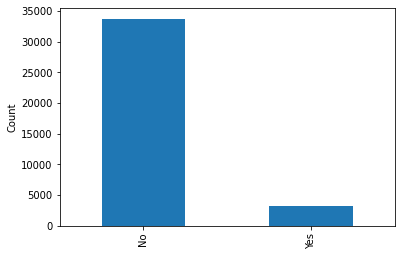

In [ ]:
# Define X and y

X = df.drop('y', axis=1)
y = df.y

# Visualize class distribution

y.value_counts().plot(kind='bar')
plt.xticks([0,1], ['No', 'Yes'])
plt.ylabel('Count');

Se divide el dataset en train y test.

In [ ]:
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

Estandarización de los datos, usando el método de MinMaxScaler, cómo medida necesaria para aplicación del algoritmo KNN y el análisis PCA, esto porque son métodos basados en distancia y sus resultados se pueden ver afectados por las distintas dimensiones de los datos.

In [ ]:
#Estandarizar x_train

columns = X.columns
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train,columns=[columns])
X_train.head()

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,education_secondary,education_tertiary,default_yes,housing_yes,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,loan_yes,contact_telephone
0,0.818182,0.360067,0.466667,0.268750,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.246753,0.328579,0.900000,0.060938,0.00,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.051948,0.480459,0.366667,0.282813,0.75,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.519481,0.600667,0.600000,0.200000,0.25,0.269495,0.034483,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.246753,0.524356,0.433333,0.864063,0.25,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Estandarizar x_test

columns = X.columns
scaler = MinMaxScaler()
X_test = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test,columns=[columns])
X_test.head()

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,education_secondary,education_tertiary,default_yes,housing_yes,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,loan_yes,contact_telephone
0,0.222222,0.352875,0.233333,0.334898,0.25,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.236111,0.343323,0.033333,0.209703,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.388889,0.895861,0.166667,0.062598,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.388889,0.823750,0.633333,0.106416,0.25,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.180556,0.273647,0.866667,0.211268,0.25,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


**Entrenamiento con datos originales**

Los métodos usados en este problema de clasificación son los siguientes:


1. KNN
2. Decision Tree
3. Random Forest
4. XG Boost
5. Grandient Boosting

Se harán los diferentes ajustes metodologícos necesarios para cada uno y posteriormente, una vez identificado el que mejor se ajuste a nuestro problema, la afinación de hiperparámetros para dicho método.




*KNN*

In [ ]:
#KNN con los datos originales

Train f1 Score: 0.4799999999999999
Test f1 Score: 0.26182618261826185
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      6742
           1       0.47      0.18      0.26       658

    accuracy                           0.91      7400
   macro avg       0.70      0.58      0.61      7400
weighted avg       0.88      0.91      0.89      7400



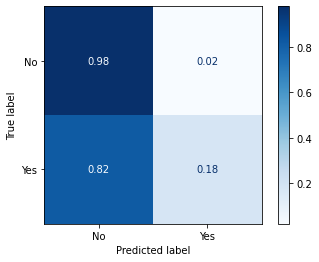

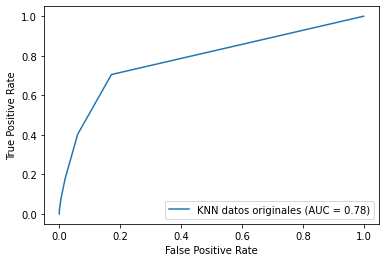

In [ ]:
# Fit k-NN classifier and make predictions
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)
    
plot_confusion_matrix(knn, X_test, y_test, display_labels=['No',
                                                          'Yes'],
                     normalize='true', cmap='Blues');

print(f'Train f1 Score: {f1_score(y_train, y_pred_train)}')
print(f'Test f1 Score: {f1_score(y_test, y_pred_test)}')
print(classification_report(y_test, y_pred_test))


#curva roc
plot_roc_curve(knn, X_test, y_test, name = 'KNN datos originales')

*Decision Tree*

Train f1 Score: 1.0
Test f1 Score: 0.4131777625257378
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      6742
           1       0.38      0.46      0.41       658

    accuracy                           0.88      7400
   macro avg       0.66      0.69      0.67      7400
weighted avg       0.90      0.88      0.89      7400



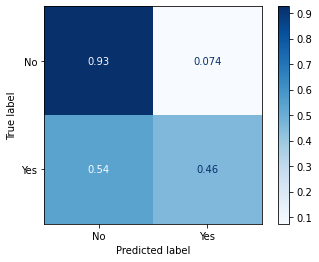

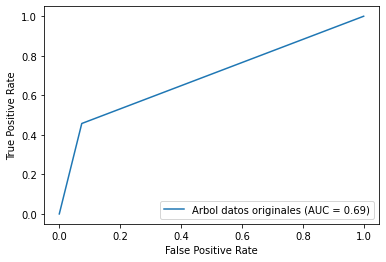

In [ ]:
#DecisionTree con Datos Originales

# Fit DecisionTree classifier and make predictions
arbol = DecisionTreeClassifier()
arbol.fit(X_train, y_train)
y_pred_train = arbol.predict(X_train)
y_pred_test = arbol.predict(X_test)

plot_confusion_matrix(arbol, X_test, y_test, display_labels=['No',
                                                          'Yes'],
                     normalize='true', cmap='Blues')
    
print(f'Train f1 Score: {f1_score(y_train, y_pred_train)}')
print(f'Test f1 Score: {f1_score(y_test, y_pred_test)}')
print(classification_report(y_test, y_pred_test))

#curva roc
plot_roc_curve(arbol, X_test, y_test, name = 'Arbol datos originales')

*Random Forest*

Train f1 Score: 0.9606267577340297
Test f1 Score: 0.4260599793174767
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      6742
           1       0.67      0.31      0.43       658

    accuracy                           0.93      7400
   macro avg       0.80      0.65      0.69      7400
weighted avg       0.91      0.93      0.91      7400



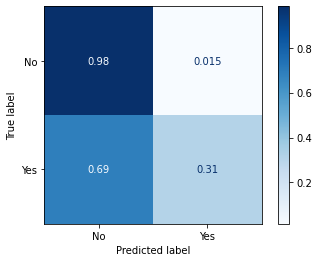

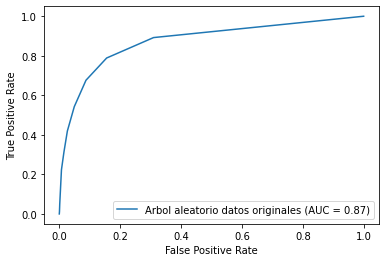

In [ ]:
#RandomForest con Datos Originales

# Creación del modelo
# ==============================================================================
arbol_aleatorio = RandomForestClassifier(
            n_estimators = 10,
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

# Entrenamiento del modelo
# ==============================================================================
arbol_aleatorio.fit(X_train, y_train)

y_pred_train = arbol_aleatorio.predict(X_train)
y_pred_test = arbol_aleatorio.predict(X_test)

plot_confusion_matrix(arbol_aleatorio, X_test, y_test, display_labels=['No',
                                                          'Yes'],
                     normalize='true', cmap='Blues');

print(f'Train f1 Score: {f1_score(y_train, y_pred_train)}')
print(f'Test f1 Score: {f1_score(y_test, y_pred_test)}')
print(classification_report(y_test, y_pred_test))

#curva roc
plot_roc_curve(arbol_aleatorio, X_test, y_test, name = 'Arbol aleatorio datos originales')

*XG Boost*

Train f1 Score: 0.4046179219351292
Test f1 Score: 0.37108953613807977
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      6742
           1       0.64      0.26      0.37       658

    accuracy                           0.92      7400
   macro avg       0.79      0.62      0.66      7400
weighted avg       0.91      0.92      0.91      7400



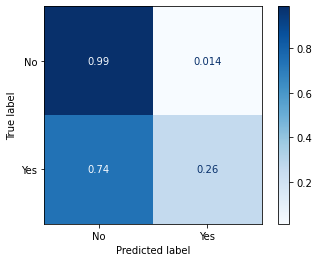

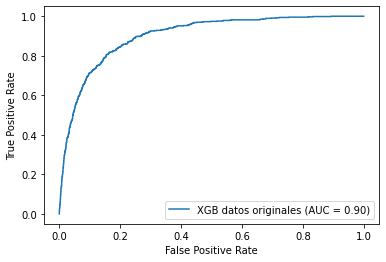

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)
    
plot_confusion_matrix(xgb, X_test, y_test, display_labels=['No',
                                                          'Yes'],
                     normalize='true', cmap='Blues');

print(f'Train f1 Score: {f1_score(y_train, y_pred_train)}')
print(f'Test f1 Score: {f1_score(y_test, y_pred_test)}')
print(classification_report(y_test, y_pred_test))


#curva roc
plot_roc_curve(xgb, X_test, y_test, name = 'XGB datos originales')

Gradient Boosting

Train f1 Score: 0.44367877020938246
Test f1 Score: 0.39103869653767814
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      6742
           1       0.59      0.29      0.39       658

    accuracy                           0.92      7400
   macro avg       0.76      0.64      0.67      7400
weighted avg       0.90      0.92      0.91      7400



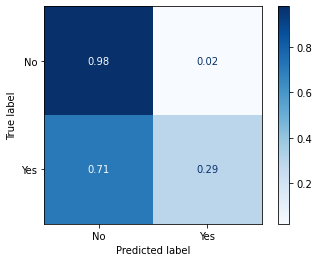

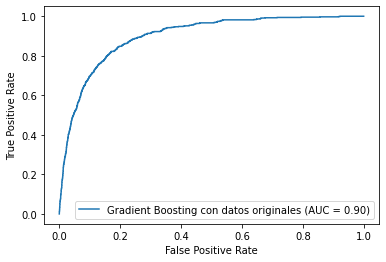

In [ ]:
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)

y_pred_train = gb_clf.predict(X_train)
y_pred_test = gb_clf.predict(X_test)
    
plot_confusion_matrix(gb_clf, X_test, y_test, display_labels=['No',
                                                          'Yes'],
                     normalize='true', cmap='Blues');

#curva roc
plot_roc_curve(gb_clf, X_test, y_test, name = 'Gradient Boosting con datos originales')

print(f'Train f1 Score: {f1_score(y_train, y_pred_train)}')
print(f'Test f1 Score: {f1_score(y_test, y_pred_test)}')
print(classification_report(y_test, y_pred_test))

Se obtiene buen accuracy en el entrenamiento de los datos originales, sin embargo esta métrica es engañosa ya que los datos están desbanlanceados. Por tanto se seguirá evaluando el desempeño de los modelos a partir de las métricas f-1 score y el AUC score.

In [ ]:
metricas_do = pd.DataFrame()

modelos = ['KNN DO', 'Decision Tree DO', 'Random Forest DO', 'XG Boost DO', 'Gradient Boosting DO']
accuracy_do = [0.91, 0.88, 0.93, 0.92, 0.92]
precision_do = [0.47, 0.37, 0.67, 0.64, 0.59]
recall_do = [0.18, 0.44, 0.31, 0.26, 0.29]
f1_train = [0.47, 1, 0.96, 0.40, 0.44]
f1_test = [0.26, 0.40, 0.42, 0.37, 0.39]
AUC = [0.78, 0.69, 0.87, 0.90, 0.90]
metricas_do['modelo'] = modelos
metricas_do['Accuracy'] = accuracy_do
metricas_do['Precision'] = precision_do
metricas_do['Recall'] = recall_do
metricas_do['Valor Train f1 Score'] = f1_train
metricas_do['Valor Test f1 Score'] = f1_test
metricas_do['Curva ROC AUC'] = AUC
metricas_do.index = np.arange(1, len(metricas_do)+1)
metricas_do.sort_values(by=['Valor Train f1 Score', 'Valor Test f1 Score'], ascending=False)
#metricas_do['índice'] = metricas_do.index

,modelo,Accuracy,Precision,Recall,Valor Train f1 Score,Valor Test f1 Score,Curva ROC AUC
2,Decision Tree DO,0.88,0.37,0.44,1.00,0.40,0.69
3,Random Forest DO,0.93,0.67,0.31,0.96,0.42,0.87
1,KNN DO,0.91,0.47,0.18,0.47,0.26,0.78
5,Gradient Boosting DO,0.92,0.59,0.29,0.44,0.39,0.90
4,XG Boost DO,0.92,0.64,0.26,0.40,0.37,0.90


**Aplicar balanceo de datos y entrenar con datos balanceados**

Dado el desbalanceo en los datos, el 95% de las datos son de clientes que dijeron NO al CDT, la clase minoritaria no logra ser correctamente identificada.Por esto se aplicará un método de balanceo sobre los datos y se entrenará nuevamente el modelo.
Para decidir qué método de balanceo usar, se aplicarán los siguientes métodos sobre el random forest y el que obtenga el mejor resultado se replicará a los demás.


1.  Smote
2.  Random Oversampling
3. Random Undersampling
4. Adasyn








*SMOTE*

In [ ]:
#Applying SMOTE on the trainingg data

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 12)
X_train_sm, y_train_sm = sm.fit_sample(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#Checking for imbalances in the training data
y_sm = np.bincount(y_train_sm)
i = np.nonzero(y_sm)[0]
np.vstack((i,y_sm[i])).T

array([[    0, 27018],
       [    1, 27018]])

ENTRENAMIENTO RANDOM FOREST + SMOTE

Train f1 Score: 0.9983703703703705
Test f1 Score: 0.54292343387471
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      6742
           1       0.55      0.53      0.54       658

    accuracy                           0.92      7400
   macro avg       0.75      0.75      0.75      7400
weighted avg       0.92      0.92      0.92      7400



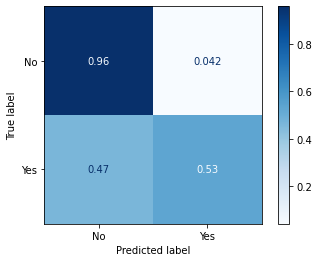

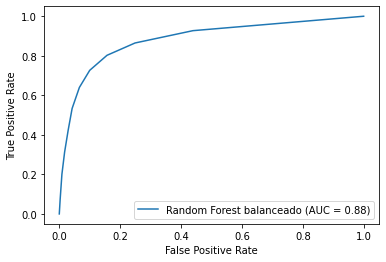

In [ ]:
# RandomForest + Balanceo de datos
# ==============================================================================
arbol_aleatorio_balanceo = RandomForestClassifier(
            n_estimators = 10,
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

# Random Forest
# ==============================================================================
arbol_aleatorio_balanceo.fit(X_train_sm, y_train_sm)

y_pred_train = arbol_aleatorio_balanceo.predict(X_train_sm)
y_pred_test = arbol_aleatorio_balanceo.predict(X_test)

plot_confusion_matrix(arbol_aleatorio_balanceo, X_test, y_test, display_labels=['No',
                                                          'Yes'],
                     normalize='true', cmap='Blues');

print(f'Train f1 Score: {f1_score(y_train_sm, y_pred_train)}')
print(f'Test f1 Score: {f1_score(y_test, y_pred_test)}')
print(classification_report(y_test, y_pred_test))

#curva roc
plot_roc_curve(arbol_aleatorio_balanceo, X_test, y_test, name = 'Random Forest balanceado')

*RANDOM OVERSAMPLING*

In [ ]:
from imblearn.over_sampling import RandomOverSampler

over = RandomOverSampler()
X_train_sm, y_train_sm = over.fit_sample(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#Checking for imbalances in the training data
y_sm = np.bincount(y_train_sm)
i = np.nonzero(y_sm)[0]
np.vstack((i,y_sm[i])).T

array([[    0, 27018],
       [    1, 27018]])

ENTRENAMIENTO RANDOM FOREST + RANDOM OVERSAMPLING

Train f1 Score: 0.9996854938671303
Test f1 Score: 0.485473289597001
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      6742
           1       0.63      0.39      0.49       658

    accuracy                           0.93      7400
   macro avg       0.79      0.69      0.72      7400
weighted avg       0.92      0.93      0.92      7400



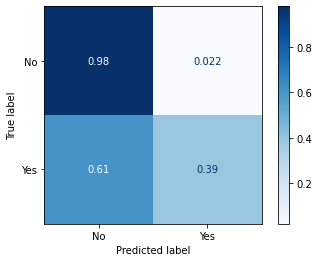

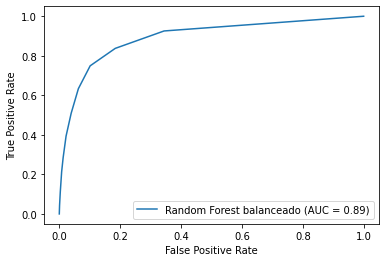

In [ ]:
# Random Forest
# ==============================================================================
arbol_aleatorio_balanceo.fit(X_train_sm, y_train_sm)

y_pred_train = arbol_aleatorio_balanceo.predict(X_train_sm)
y_pred_test = arbol_aleatorio_balanceo.predict(X_test)

plot_confusion_matrix(arbol_aleatorio_balanceo, X_test, y_test, display_labels=['No',
                                                          'Yes'],
                     normalize='true', cmap='Blues');

print(f'Train f1 Score: {f1_score(y_train_sm, y_pred_train)}')
print(f'Test f1 Score: {f1_score(y_test, y_pred_test)}')
print(classification_report(y_test, y_pred_test))

#curva roc
plot_roc_curve(arbol_aleatorio_balanceo, X_test, y_test, name = 'Random Forest balanceado')

*RANDOM UNDERSAMPLING*

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

under = RandomUnderSampler()
X_train_sm, y_train_sm = under.fit_sample(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#Checking for imbalances in the training data
y_sm = np.bincount(y_train_sm)
i = np.nonzero(y_sm)[0]
np.vstack((i,y_sm[i])).T

array([[   0, 2579],
       [   1, 2579]])

ENTRENAMIENTO RANDOM FOREST + RANDOM UNDERSAMPLING

Train f1 Score: 0.9916521063871093
Test f1 Score: 0.44989429175475687
              precision    recall  f1-score   support

           0       0.98      0.83      0.90      6742
           1       0.31      0.81      0.45       658

    accuracy                           0.82      7400
   macro avg       0.64      0.82      0.67      7400
weighted avg       0.92      0.82      0.86      7400



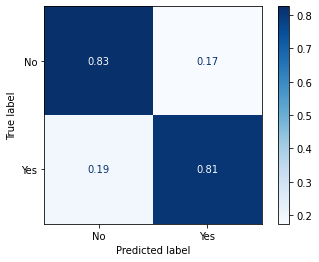

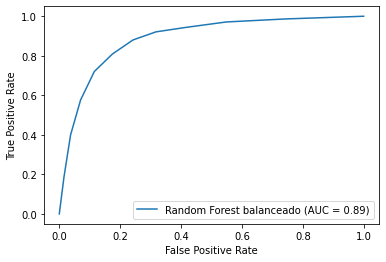

In [ ]:
# Random Forest
# ==============================================================================
arbol_aleatorio_balanceo.fit(X_train_sm, y_train_sm)

y_pred_train = arbol_aleatorio_balanceo.predict(X_train_sm)
y_pred_test = arbol_aleatorio_balanceo.predict(X_test)

plot_confusion_matrix(arbol_aleatorio_balanceo, X_test, y_test, display_labels=['No',
                                                          'Yes'],
                     normalize='true', cmap='Blues');

print(f'Train f1 Score: {f1_score(y_train_sm, y_pred_train)}')
print(f'Test f1 Score: {f1_score(y_test, y_pred_test)}')
print(classification_report(y_test, y_pred_test))

#curva roc
plot_roc_curve(arbol_aleatorio_balanceo, X_test, y_test, name = 'Random Forest balanceado')

*ADASYN*

In [ ]:
from imblearn.over_sampling import ADASYN

ADA = ADASYN()
X_train_sm, y_train_sm = ADA.fit_sample(X_train,y_train)


#Checking for imbalances in the training data
y_sm = np.bincount(y_train_sm)
i = np.nonzero(y_sm)[0]
np.vstack((i,y_sm[i])).T

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


array([[    0, 27018],
       [    1, 26882]])

ENTRENAMIENTO RANDOM FOREST + ADASYN

Train f1 Score: 0.9983435388710008
Test f1 Score: 0.5138888888888888
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      6742
           1       0.52      0.51      0.51       658

    accuracy                           0.91      7400
   macro avg       0.74      0.73      0.73      7400
weighted avg       0.91      0.91      0.91      7400



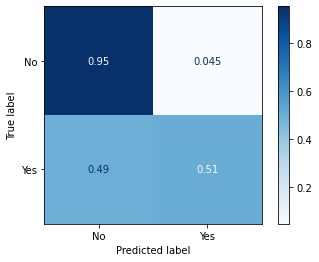

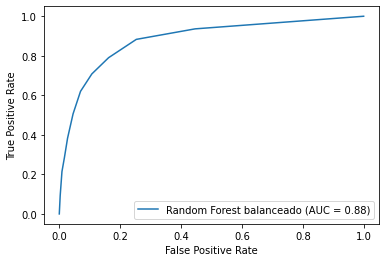

In [ ]:
# Random Forest
# ==============================================================================
arbol_aleatorio_balanceo.fit(X_train_sm, y_train_sm)

y_pred_train = arbol_aleatorio_balanceo.predict(X_train_sm)
y_pred_test = arbol_aleatorio_balanceo.predict(X_test)

plot_confusion_matrix(arbol_aleatorio_balanceo, X_test, y_test, display_labels=['No',
                                                          'Yes'],
                     normalize='true', cmap='Blues');

print(f'Train f1 Score: {f1_score(y_train_sm, y_pred_train)}')
print(f'Test f1 Score: {f1_score(y_test, y_pred_test)}')
print(classification_report(y_test, y_pred_test))

#curva roc
plot_roc_curve(arbol_aleatorio_balanceo, X_test, y_test, name = 'Random Forest balanceado')

In [ ]:
metricas_balanceo = pd.DataFrame()

modelos = ['RANDOM FOREST SMOTE', 'RANDOM FOREST RANDOM OVERSAMPLING', 'RANDOM FOREST RANDOM UNDERSAMPLING', 'RANDOM FOREST ADASYN']
f1_train = [0.99, 0.99, 0.99, 0.99]
f1_test = [0.54, 0.46, 0.47, 0.53]
AUC = [0.88, 0.89, 0.90, 0.89]
metricas_balanceo['modelo'] = modelos
metricas_balanceo['Valor Train f1 Score'] = f1_train
metricas_balanceo['Valor Test f1 Score'] = f1_test
metricas_balanceo['Curva ROC AUC'] = AUC
metricas_balanceo.index = np.arange(1, len(metricas_balanceo)+1)
metricas_balanceo.sort_values(by=['Valor Train f1 Score', 'Valor Test f1 Score'], ascending=False, ignore_index=True)

,modelo,Valor Train f1 Score,Valor Test f1 Score,Curva ROC AUC
0,RANDOM FOREST SMOTE,0.99,0.54,0.88
1,RANDOM FOREST ADASYN,0.99,0.53,0.89
2,RANDOM FOREST RANDOM UNDERSAMPLING,0.99,0.47,0.90
3,RANDOM FOREST RANDOM OVERSAMPLING,0.99,0.46,0.89


Los mejores resultados se obtuvieron con el método de balanceo SMOTE. 

Se procede entonces a entrenar los modelos con este método.

**Entrenamiento con datos balanceados**

SMOTE

In [ ]:
#Applying SMOTE on the trainingg data

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 12)
X_train_sm, y_train_sm = sm.fit_sample(X_train,y_train)

#Checking for imbalances in the training data
y_sm = np.bincount(y_train_sm)
i = np.nonzero(y_sm)[0]
np.vstack((i,y_sm[i])).T

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


array([[    0, 27018],
       [    1, 27018]])

*KNN*

Train f1 Score: 0.9536201097539387
Test f1 Score: 0.4313725490196078
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      6742
           1       0.33      0.64      0.43       658

    accuracy                           0.85      7400
   macro avg       0.64      0.75      0.67      7400
weighted avg       0.90      0.85      0.87      7400



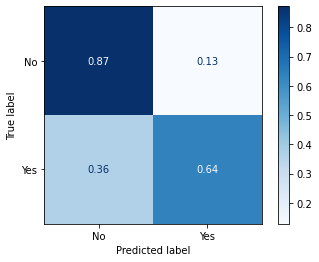

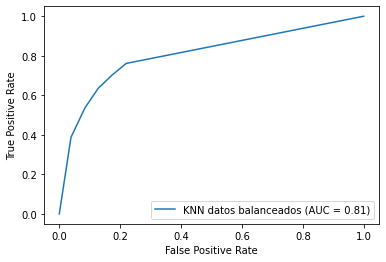

In [ ]:
# Fit k-NN classifier and make predictions
# KNN con datos balanceados

knn = KNeighborsClassifier()
knn.fit(X_train_sm, y_train_sm)
y_pred_train = knn.predict(X_train_sm)
y_pred_test = knn.predict(X_test)

plot_confusion_matrix(knn, X_test, y_test, display_labels=['No',
                                                          'Yes'],
                     normalize='true', cmap='Blues');
    
print(f'Train f1 Score: {f1_score(y_train_sm, y_pred_train)}')
print(f'Test f1 Score: {f1_score(y_test, y_pred_test)}')
print(classification_report(y_test, y_pred_test))

#curva roc
plot_roc_curve(knn, X_test, y_test, name = 'KNN datos balanceados')

*Random Forest*

Train f1 Score: 0.9983703703703705
Test f1 Score: 0.54292343387471
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      6742
           1       0.55      0.53      0.54       658

    accuracy                           0.92      7400
   macro avg       0.75      0.75      0.75      7400
weighted avg       0.92      0.92      0.92      7400



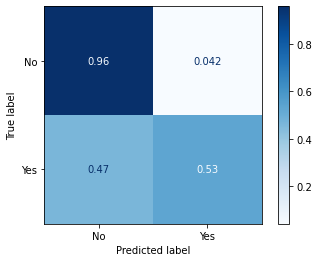

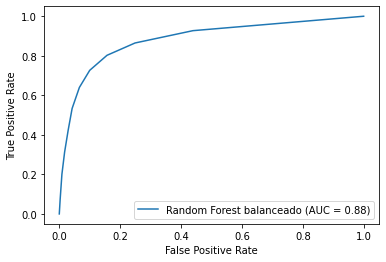

In [ ]:
# RandomForest + Balanceo de datos
# ==============================================================================
arbol_aleatorio_balanceo = RandomForestClassifier(
            n_estimators = 10,
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

# Entrenamiento del modelo
# ==============================================================================
arbol_aleatorio_balanceo.fit(X_train_sm, y_train_sm)

y_pred_train = arbol_aleatorio_balanceo.predict(X_train_sm)
y_pred_test = arbol_aleatorio_balanceo.predict(X_test)

plot_confusion_matrix(arbol_aleatorio_balanceo, X_test, y_test, display_labels=['No',
                                                          'Yes'],
                     normalize='true', cmap='Blues');

print(f'Train f1 Score: {f1_score(y_train_sm, y_pred_train)}')
print(f'Test f1 Score: {f1_score(y_test, y_pred_test)}')
print(classification_report(y_test, y_pred_test))

#curva roc
plot_roc_curve(arbol_aleatorio_balanceo, X_test, y_test, name = 'Random Forest balanceado')

XG Boost

Train f1 Score: 0.911579372806937
Test f1 Score: 0.4928457869634341
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      6742
           1       0.38      0.71      0.49       658

    accuracy                           0.87      7400
   macro avg       0.67      0.80      0.71      7400
weighted avg       0.92      0.87      0.89      7400



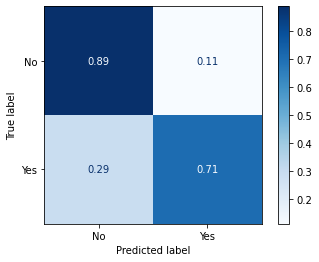

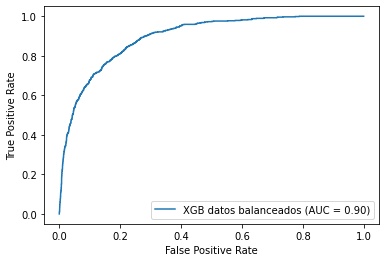

In [ ]:
train_x = X_train_sm
test_x = X_test.values
train_y = y_train_sm
test_y = y_test.values

xgb = XGBClassifier()
xgb.fit(train_x, train_y)
y_pred_train = xgb.predict(train_x)
y_pred_test = xgb.predict(test_x)
    
plot_confusion_matrix(xgb, test_x, test_y, display_labels=['No',
                                                          'Yes'],
                     normalize='true', cmap='Blues');

print(f'Train f1 Score: {f1_score(train_y, y_pred_train)}')
print(f'Test f1 Score: {f1_score(test_y, y_pred_test)}')
print(classification_report(test_y, y_pred_test))


#curva roc
plot_roc_curve(xgb, test_x, test_y, name = 'XGB datos balanceados')

Gradient Boost

Train f1 Score: 0.9134094230377919
Test f1 Score: 0.49616648411829134
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      6742
           1       0.39      0.69      0.50       658

    accuracy                           0.88      7400
   macro avg       0.68      0.79      0.71      7400
weighted avg       0.92      0.88      0.89      7400



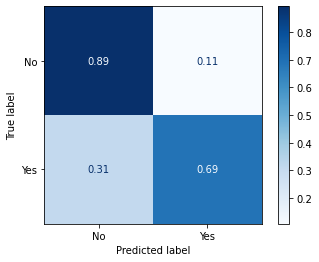

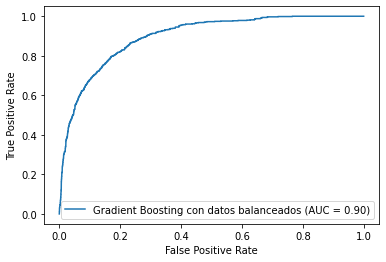

In [ ]:
train_x = X_train_sm
test_x = X_test.values
train_y = y_train_sm
test_y = y_test.values

gb_clf = GradientBoostingClassifier()
gb_clf.fit(train_x, train_y)
y_pred_train = gb_clf.predict(train_x)
y_pred_test = gb_clf.predict(test_x)
    
plot_confusion_matrix(gb_clf, test_x, test_y, display_labels=['No',
                                                          'Yes'],
                     normalize='true', cmap='Blues');

print(f'Train f1 Score: {f1_score(train_y, y_pred_train)}')
print(f'Test f1 Score: {f1_score(test_y, y_pred_test)}')
print(classification_report(test_y, y_pred_test))


#curva roc
plot_roc_curve(gb_clf, test_x, test_y, name = 'Gradient Boosting con datos balanceados')

In [ ]:
metricas_do = pd.DataFrame()

modelos = ['KNN DB', 'Random Forest DB', 'XG Boost DB', 'Gradient Boosting DB']
f1_train = [0.95, 0.99, 0.91, 0.91]
f1_test = [0.43, 0.54, 0.49, 0.49]
AUC = [0.81, 0.88, 0.90, 0.90]
metricas_do['modelo'] = modelos
metricas_do['Valor Train f1 Score'] = f1_train
metricas_do['Valor Test f1 Score'] = f1_test
metricas_do['Curva ROC AUC'] = AUC
metricas_do.sort_values(by=['Valor Train f1 Score', 'Valor Test f1 Score'], ascending=False, ignore_index=True)

,modelo,Valor Train f1 Score,Valor Test f1 Score,Curva ROC AUC
0,Random Forest DB,0.99,0.54,0.88
1,KNN DB,0.95,0.43,0.81
2,XG Boost DB,0.91,0.49,0.90
3,Gradient Boosting DB,0.91,0.49,0.90


**Análisis PCA**

Se aplica el análisis de componentes principales con el propósito de reducir los tiempos de ejecución, especialmente en la aplicación de KNN, e identificar si hay mejoras en los resultados al descartar las variables "menos importantes"

Gráfica de la varianza explicada.

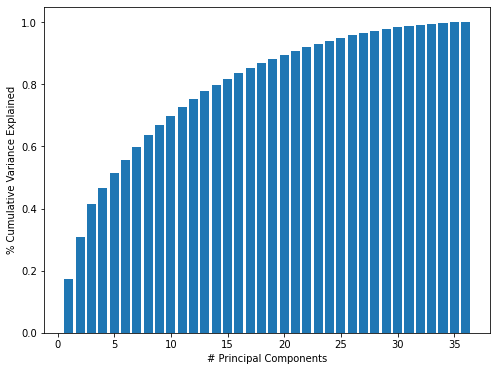

In [ ]:
 #Calcular la varianza acumulada para todos los componentes

pca = PCA(n_components=36)
pca.fit(X_train_sm)

cum_exp_var = []
var_exp = 0
for i in pca.explained_variance_ratio_:
    var_exp += i
    cum_exp_var.append(var_exp)

#Gráfica

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(range(1,37), cum_exp_var)
ax.set_xlabel('# Principal Components')
ax.set_ylabel('% Cumulative Variance Explained');

Se identifica que a partir de 10 componentes se explica el 70% de la varianza.

In [ ]:
# Función para identificar el número de componentes que explican x % de la varianza, para nuestro caso 70%
# PCA
# https://towardsdatascience.com/one-hot-encoding-standardization-pca-data-preparation-steps-for-segmentation-in-python-24d07671cf0b
from sklearn.decomposition import PCA

for comp in range(3, X.shape[1]):
    pca = PCA(n_components= comp, random_state=42)
    pca.fit(X_train_sm)
    comp_check = pca.explained_variance_ratio_
    final_comp = comp
    if comp_check.sum() > 0.70:
        break
        
Final_PCA = PCA(n_components= final_comp,random_state=42)
Final_PCA.fit(df)
cluster_df=Final_PCA.transform(df)
num_comps = comp_check.shape[0]
print("Using {} components, we can explain {}% of the variability in the original data.".format(final_comp,comp_check.sum()*100))

Using 11 components, we can explain 72.56912604889624% of the variability in the original data.


Se aplica el PCA con 15 componentes a los conjuntos de datos train y test.

In [ ]:
# el PCA debe explicar + del 50%
pca = PCA(n_components=15)
pca.fit(X_train_sm)

X_train_pca = pca.transform(X_train_sm)
X_test_pca = pca.transform(X_test)

**Entrenamiento con PCA**

*KNN*

In [ ]:
# Fit k-NN classifier and make predictions
knn = KNeighborsClassifier()
knn.fit(X_train_pca, y_train_sm)
y_pred_train = knn.predict(X_train_pca)
y_pred_test = knn.predict(X_test_pca)
    
print(f'Train f1 Score: {f1_score(y_train_sm, y_pred_train)}')
print(f'Test f1 Score: {f1_score(y_test, y_pred_test)}')
print(classification_report(y_test, y_pred_test))

Train f1 Score: 0.9426923898341283
Test f1 Score: 0.41841432225063935
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      6742
           1       0.32      0.62      0.42       658

    accuracy                           0.85      7400
   macro avg       0.64      0.74      0.66      7400
weighted avg       0.90      0.85      0.87      7400



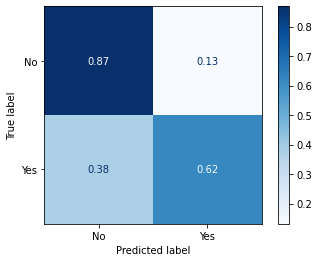

In [ ]:
plot_confusion_matrix(knn, X_test_pca, y_test, display_labels=['No',
                                                          'Yes'],
                     normalize='true', cmap='Blues');

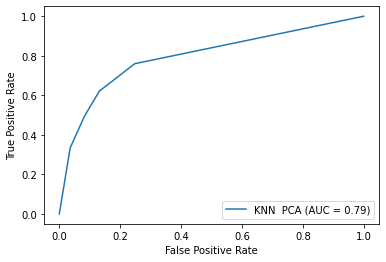

In [ ]:
#curva roc
plot_roc_curve(knn, X_test_pca, y_test, name = 'KNN  PCA')

*Random Forest*

In [ ]:
# RandomForest + Balanceo de datos + PCA
# ==============================================================================
arbol_aleatorio_pca = RandomForestClassifier(
            n_estimators = 100,
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

# Entrenamiento del modelo
# ==============================================================================
arbol_aleatorio_pca.fit(X_train_pca, y_train_sm)

y_pred_train = arbol_aleatorio_pca.predict(X_train_pca)
y_pred_test = arbol_aleatorio_pca.predict(X_test_pca)

print(f'Train f1 Score: {f1_score(y_train_sm, y_pred_train)}')
print(f'Test f1 Score: {f1_score(y_test, y_pred_test)}')
print(classification_report(y_test, y_pred_test))

Train f1 Score: 0.9999814934764505
Test f1 Score: 0.4833555259653795
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      6742
           1       0.43      0.55      0.48       658

    accuracy                           0.90      7400
   macro avg       0.69      0.74      0.71      7400
weighted avg       0.91      0.90      0.90      7400



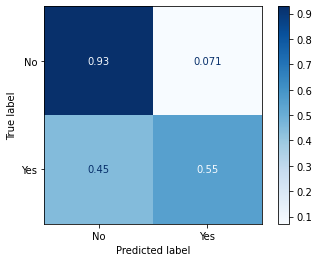

In [ ]:
plot_confusion_matrix(arbol_aleatorio_pca, X_test_pca, y_test, display_labels=['No',
                                                          'Yes'],
                     normalize='true', cmap='Blues');

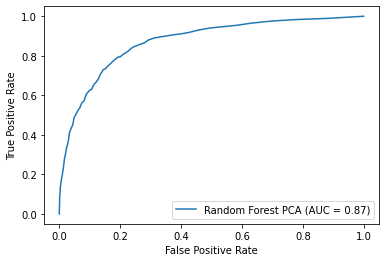

In [ ]:
#curva roc
plot_roc_curve(arbol_aleatorio_pca, X_test_pca, y_test, name = 'Random Forest PCA')

*XG BOOST*

Train f1 Score: 0.8072360723607236
Test f1 Score: 0.37289404717334335
              precision    recall  f1-score   support

           0       0.97      0.78      0.86      6742
           1       0.25      0.76      0.37       658

    accuracy                           0.77      7400
   macro avg       0.61      0.77      0.62      7400
weighted avg       0.91      0.77      0.82      7400



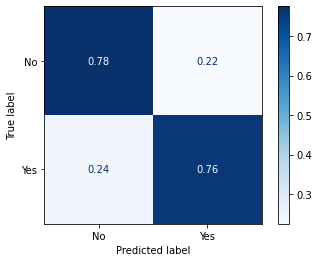

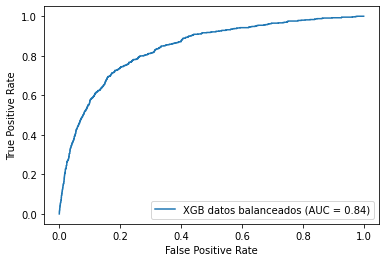

In [ ]:
train_x = X_train_pca
test_x = X_test_pca
train_y = y_train_sm
test_y = y_test.values

xgb = XGBClassifier()
xgb.fit(train_x, train_y)
y_pred_train = xgb.predict(train_x)
y_pred_test = xgb.predict(test_x)
    
plot_confusion_matrix(xgb, test_x, test_y, display_labels=['No',
                                                          'Yes'],
                     normalize='true', cmap='Blues');

print(f'Train f1 Score: {f1_score(train_y, y_pred_train)}')
print(f'Test f1 Score: {f1_score(test_y, y_pred_test)}')
print(classification_report(test_y, y_pred_test))


#curva roc
plot_roc_curve(xgb, test_x, test_y, name = 'XGB datos balanceados')

*Gradient Boosting*

Train f1 Score: 0.8071896607899215
Test f1 Score: 0.3820736802126852
              precision    recall  f1-score   support

           0       0.97      0.78      0.87      6742
           1       0.25      0.76      0.38       658

    accuracy                           0.78      7400
   macro avg       0.61      0.77      0.62      7400
weighted avg       0.91      0.78      0.82      7400



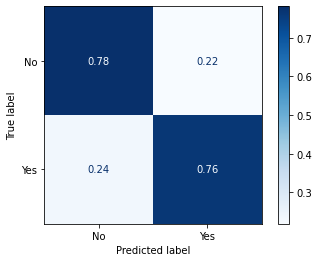

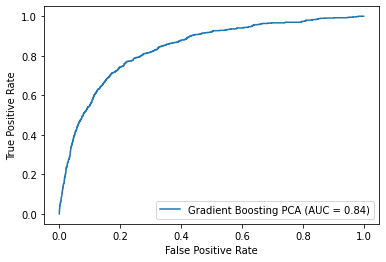

In [ ]:
train_x = X_train_pca
test_x = X_test_pca
train_y = y_train_sm
test_y = y_test.values

gb_clf = GradientBoostingClassifier()
gb_clf.fit(train_x, train_y)
y_pred_train = gb_clf.predict(train_x)
y_pred_test = gb_clf.predict(test_x)
    
plot_confusion_matrix(gb_clf, test_x, test_y, display_labels=['No',
                                                          'Yes'],
                     normalize='true', cmap='Blues');

print(f'Train f1 Score: {f1_score(train_y, y_pred_train)}')
print(f'Test f1 Score: {f1_score(test_y, y_pred_test)}')
print(classification_report(test_y, y_pred_test))


#curva roc
plot_roc_curve(gb_clf, test_x, test_y, name = 'Gradient Boosting PCA')

In [ ]:
metricas_do = pd.DataFrame()

modelos = ['KNN PCA', 'Random Forest PCA', 'XG Boost PCA', 'Gradient Boosting PCA']
f1_train = [0.94, 0.99, 0.80, 0.80]
f1_test = [0.41, 0.47, 0.37, 0.37]
AUC = [0.79, 0.87, 0.84, 0.84]
metricas_do['modelo'] = modelos
metricas_do['Valor Train f1 Score'] = f1_train
metricas_do['Valor Test f1 Score'] = f1_test
metricas_do['Curva ROC AUC'] = AUC
metricas_do.sort_values(by=['Valor Train f1 Score', 'Valor Test f1 Score'], ascending=False, ignore_index=True)

,modelo,Valor Train f1 Score,Valor Test f1 Score,Curva ROC AUC
0,Random Forest PCA,0.99,0.47,0.87
1,KNN PCA,0.94,0.41,0.79
2,XG Boost PCA,0.80,0.37,0.84
3,Gradient Boosting PCA,0.80,0.37,0.84


In [ ]:
metricas_sub = pd.DataFrame()

modelos = ['KNN DO', 'Decision Tree DO', 'Random Forest DO', 'XG Boost DO', 'Gradient Boosting DO', 'KNN DB', 'Random Forest DB', 'XG Boost DB', 'Gradient Boosting DB', 'KNN PCA', 'Random Forest PCA', 'XG Boost PCA', 'Gradient Boosting PCA']
f1_train = [0.47, 1, 0.96, 0.40, 0.44, 0.95, 0.99, 0.91, 0.91, 0.94, 0.99, 0.80, 0.80]
f1_test = [0.26, 0.40, 0.42, 0.37, 0.39, 0.43, 0.54, 0.49, 0.49, 0.41, 0.47, 0.37, 0.37]
AUC = [0.78, 0.69, 0.87, 0.90, 0.90, 0.81, 0.88, 0.90, 0.90, 0.79, 0.87, 0.84, 0.84]
metricas_sub['modelo'] = modelos
metricas_sub['Valor Train f1 Score'] = f1_train
metricas_sub['Valor Test f1 Score'] = f1_test
metricas_sub['Curva ROC AUC'] = AUC
metricas_sub.sort_values(by=['Valor Train f1 Score', 'Valor Test f1 Score'], ascending=False, ignore_index=True)
metricas_sub

,modelo,Valor Train f1 Score,Valor Test f1 Score,Curva ROC AUC
0,KNN DO,0.47,0.26,0.78
1,Decision Tree DO,1.00,0.40,0.69
2,Random Forest DO,0.96,0.42,0.87
3,XG Boost DO,0.40,0.37,0.90
4,Gradient Boosting DO,0.44,0.39,0.90
5,KNN DB,0.95,0.43,0.81
6,Random Forest DB,0.99,0.54,0.88
7,XG Boost DB,0.91,0.49,0.90
8,Gradient Boosting DB,0.91,0.49,0.90
9,KNN PCA,0.94,0.41,0.79


De acuerdo con los resultados anteriores, el Random Forest con los datos balanceados a través del método SMOTE, es el modelo con el mejor rendimiento de acuerdo con las métricas seleccionadas. 

Se procederá entonces a estimar hiperparámetros sobre éste para mejorar su rendimiento.

## **Estimación de Hiperparámetros**

1. Se utilizó la curva de aprendizaje para estimar el mejor valor para el parámetro n_estimators, el cual quedó establecido primeramente en 121 en la ejcución de un rango de 0 a 200 n_estimators.

0.902044752781979 121


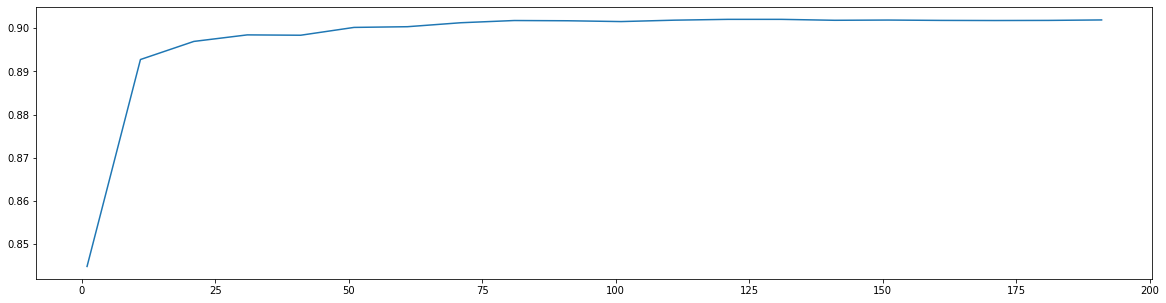

In [ ]:
from sklearn.model_selection import cross_val_score

arbol_aleatorio_mejorado = RandomForestClassifier()
score_pre = cross_val_score(arbol_aleatorio_mejorado, X_train_sm, y_train_sm, cv=10).mean()
score_pre

scorel = []
for i in range(0,200,10):
	arbol_aleatorio_mejorado = RandomForestClassifier(n_estimators=i+1,n_jobs=-1,random_state=9)
	score = cross_val_score(arbol_aleatorio_mejorado, X_train_sm, y_train_sm, cv=10).mean()
	scorel.append(score)
print(max(scorel),(scorel.index(max(scorel))*10)+1)
plt.figure(figsize=[20,5])
plt.plot(range(1,201,10),scorel)
plt.show()

Se ajustó el rango de acuerdo con la información proporcionada por la curva de aprendizaje de la primera ejecución, entre 110 a 130 n_estimators y se realizó de nuevo la medición, la cual quedó establecida sobre 115 n_estimators.

0.9676519322749252 115


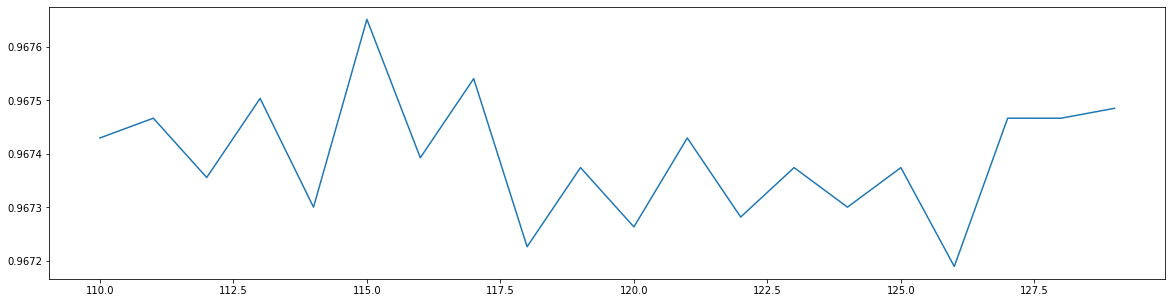

In [ ]:
scorel = []
for i in range(110, 130):
	arbol_aleatorio_mejorado = RandomForestClassifier(n_estimators=i+1,n_jobs=-1,random_state=9)
	score = cross_val_score(arbol_aleatorio_mejorado, X_train_sm, y_train_sm, cv=10).mean()
	scorel.append(score)
print(max(scorel),([*range(110,130)][scorel.index(max(scorel))]))
plt.figure(figsize=[20,5])
plt.plot(range(110, 130),scorel)
plt.show()

2. Se procedió a ejecutar la curva de aprendizaje para encontrar el mejor valor de capas de profundidad para el parámetro max_depth, el cual quedó establecido en 41

0.9674483690764226 41


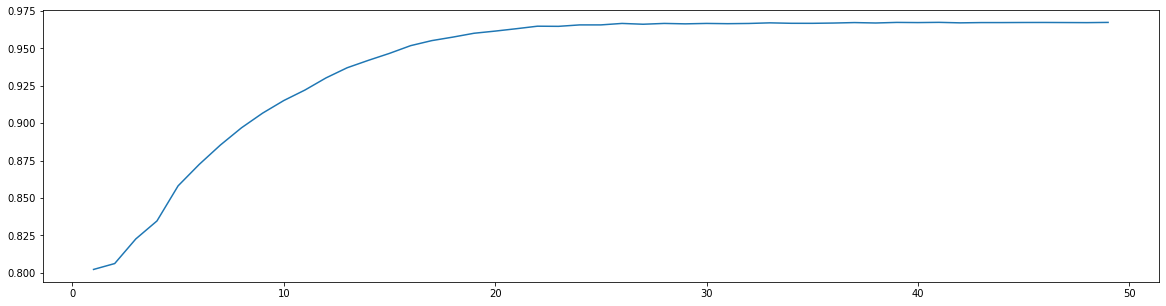

In [ ]:
scorel = []
for i in range(1, 50):
	arbol_aleatorio_mejorado = RandomForestClassifier(max_depth=i+1,n_jobs=-1,random_state=9)
	score = cross_val_score(arbol_aleatorio_mejorado, X_train_sm, y_train_sm, cv=10).mean()
	scorel.append(score)
print(max(scorel),([*range(1,50)][scorel.index(max(scorel))]))
plt.figure(figsize=[20,5])
plt.plot(range(1, 50),scorel)
plt.show()

Se entrena el modelo de nuevo con los valores de los parámetros n_estimators y max_depth obtenidos en la curva de aprendizaje. Sin embargo, para evitar el sobreajuste se define un max_depth de 28 de conformidad con la información provista por la gráfica.

Train f1 Score: 0.9996300133195205
Test f1 Score: 0.573082489146165
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      6742
           1       0.55      0.60      0.57       658

    accuracy                           0.92      7400
   macro avg       0.75      0.78      0.76      7400
weighted avg       0.92      0.92      0.92      7400



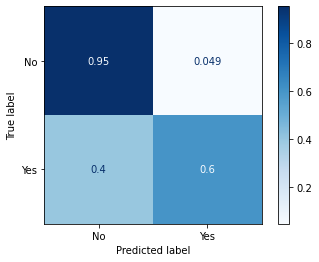

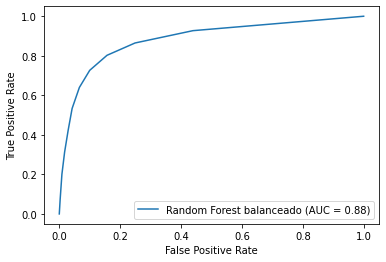

In [ ]:
arbol_aleatorio_m = RandomForestClassifier(n_estimators = 115,
            max_depth    = 28,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 90)
arbol_aleatorio_m.fit(X_train_sm, y_train_sm)

y_pred_train = arbol_aleatorio_m.predict(X_train_sm)
y_pred_test = arbol_aleatorio_m.predict(X_test)

plot_confusion_matrix(arbol_aleatorio_m, X_test, y_test, display_labels=['No', 'Yes'], normalize='true', cmap='Blues');

print(f'Train f1 Score: {f1_score(y_train_sm, y_pred_train)}')
print(f'Test f1 Score: {f1_score(y_test, y_pred_test)}')
print(classification_report(y_test, y_pred_test))

#curva roc
plot_roc_curve(arbol_aleatorio_balanceo, X_test, y_test, name = 'Random Forest balanceado')

3. Ahora bien, se estiman los valores de los parámetros criterion y max_features usando el algoritmo de Búsqueda de Cuadrícula (Grid Search)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'criterion':['gini', 'entropy']}
arbol_aleatorio_mejorado = RandomForestClassifier(n_estimators=115, max_depth=28, random_state=90)
GS = GridSearchCV(arbol_aleatorio_mejorado,param_grid,cv=10)
GS.fit(X_train_sm, y_train_sm)
print(GS.best_params_)
print(GS.best_score_)

{'criterion': 'gini'}
0.966671030007317


In [ ]:
param_grid = {'max_features':['auto', 'sqrt', 'log2', None]}
arbol_aleatorio_mejorado = RandomForestClassifier(n_estimators=115, max_depth=32, criterion='gini', random_state=90)
GS = GridSearchCV(arbol_aleatorio_mejorado,param_grid,cv=10)
GS.fit(X_train_sm, y_train_sm)
print(GS.best_params_)
print(GS.best_score_)

{'max_features': 'log2'}
0.9674298094665449


Se entrena de nuevo el modelo con todos los valores de los parámetros encontrados. 

Se logra incrementar el test f1 score a 0.59.

Train f1 Score: 0.9999814941614079
Test f1 Score: 0.5901398086828551
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      6742
           1       0.57      0.61      0.59       658

    accuracy                           0.92      7400
   macro avg       0.77      0.78      0.77      7400
weighted avg       0.93      0.92      0.93      7400



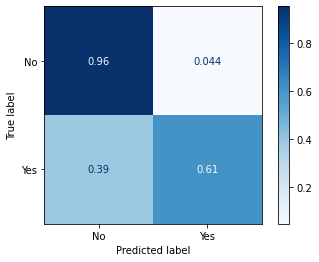

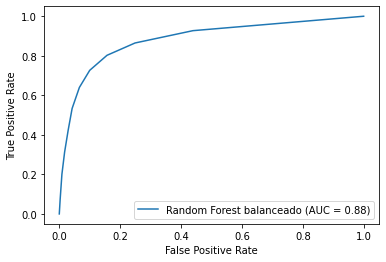

In [ ]:
arbol_aleatorio_m = RandomForestClassifier(n_estimators = 115,
            max_depth    = 32,
            max_features = 'log2',
            criterion = 'gini',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123)
arbol_aleatorio_m.fit(X_train_sm, y_train_sm)

y_pred_train = arbol_aleatorio_m.predict(X_train_sm)
y_pred_test = arbol_aleatorio_m.predict(X_test)

plot_confusion_matrix(arbol_aleatorio_m, X_test, y_test, display_labels=['No', 'Yes'], normalize='true', cmap='Blues');

print(f'Train f1 Score: {f1_score(y_train_sm, y_pred_train)}')
print(f'Test f1 Score: {f1_score(y_test, y_pred_test)}')
print(classification_report(y_test, y_pred_test))

#curva roc
plot_roc_curve(arbol_aleatorio_balanceo, X_test, y_test, name = 'Random Forest balanceado')